# OCR correction

This notebook is intended to help create rules to correct ocr

In [1]:
import pandas as pd
import re
from bs4 import BeautifulSoup
from glob import glob
import os
from tqdm import tqdm
import unidecode
import pkg_resources
from symspellpy import SymSpell, Verbosity

### Path to data to correct

In [39]:
path = '../Layout_article_dataset/train'

In [40]:

sym_spell = SymSpell()
dictionary_path = 'data/fr/fr_dic.txt'
# 0, 1 pour dic unigramme, 0,2 pour dic bigramme
sym_spell.load_dictionary(dictionary_path, 0, 1)

dictionary_path = 'data/fr/fr-100k.txt'
sym_spell.load_dictionary(dictionary_path, 0, 1)

True

In [41]:
with open('data/fr/fr_stopwords.txt', encoding='utf-8') as f:
    stopwords = f.read()
stopwords = stopwords.split('\n')
stopwords = set(stopwords)

### Creates DF to process data

In [69]:
def extract(text, regex):
    search_regex = re.search(regex, text)
    if search_regex:
        return search_regex.group(1)
    return ''
    
# subs_content

string_re = re.compile(r'<string[^>]*>')
content_re = re.compile(r'content="([^"]*)"')
wc_re = re.compile(r'wc="([^"]*)"')
id_re = re.compile(r'id="([^"]*)"')


l_df = []
for folder in tqdm(glob(f'{path}/**', recursive=True)):
    if os.path.isdir(folder):
        foldername = os.path.basename(folder)
        if foldername.startswith('bpt'):
            file = f'{folder}/{foldername}.xml'
            
            with open(file, encoding='utf-8') as f:
                xmlfile = f.read()
            stringtags = pd.Series(re.findall(string_re, xmlfile))
            contents = stringtags.apply(extract, args=(content_re,))
            wc = stringtags.apply(extract, args=(wc_re,))
            ids = stringtags.apply(extract, args=(id_re,))
            wc = wc.astype('float64')
            
            df = pd.concat([ids, contents, wc], axis=1)
            df['file'] = f'{folder}/{foldername}.xml'
            l_df.append(df)


100%|█████████████████████████████████████| 8615/8615 [00:01<00:00, 4721.50it/s]


In [7]:
def extract(text, regex):
    search_regex = re.search(regex, text)
    if search_regex:
        return search_regex.group(1)
    return ''


l_df = []
for folder in tqdm(glob(f'{path}/**', recursive=True)):
    if os.path.isdir(folder):
        foldername = os.path.basename(folder)
        if foldername.startswith('bpt'):
            file = f'{folder}/{foldername}.xml'
            
            with open(file, encoding='utf-8') as f:
                soup = BeautifulSoup(f.read(), features='lxml')
            
            stringtags = soup.find_all('string')
            ids = pd.Series([x['id'] for x in stringtags])
            contents = pd.Series([x['content'] for x in stringtags])
                
                
#             stringtags = pd.Series(re.findall(string_re, xmlfile))
#             contents = stringtags.apply(extract, args=(content_re,))
#             wc = stringtags.apply(extract, args=(wc_re,))
#             ids = stringtags.apply(extract, args=(id_re,))
#             wc = wc.astype('float64')
            
            df = pd.concat([ids, contents], axis=1)
            df['file'] = f'{folder}/{foldername}.xml'
            l_df.append(df)
            # break


100%|████████████████████████████████████████| 615/615 [00:05<00:00, 114.80it/s]


In [59]:
df = pd.concat(l_df).reset_index()
del df['index']
df.rename(columns={0:'id', 1:'content', 2:'wc'}, inplace=True)
# df.set_index('file', inplace=True)
df

,id,content,wc,file
0,PAG_00000001_ST000001,DE,0.895000,../Layout_article_dataset/train/3+c/cb32777055...
1,PAG_00000001_ST000002,PARIS,0.608000,../Layout_article_dataset/train/3+c/cb32777055...
2,PAG_00000001_ST000003,JOURNAL,0.937143,../Layout_article_dataset/train/3+c/cb32777055...
3,PAG_00000001_ST000004,D’INFORMATION,0.914615,../Layout_article_dataset/train/3+c/cb32777055...
4,PAG_00000001_ST000005,DES,0.836667,../Layout_article_dataset/train/3+c/cb32777055...
...,...,...,...,...
338578,PAG_00000016_ST000437,tous,0.442500,../Layout_article_dataset/train/1c/cb42745757w...
338579,PAG_00000016_ST000438,les,0.416667,../Layout_article_dataset/train/1c/cb42745757w...
338580,PAG_00000016_ST000439,dimanches,0.663333,../Layout_article_dataset/train/1c/cb42745757w...
338581,PAG_00000016_ST000440,et,0.455000,../Layout_article_dataset/train/1c/cb42745757w...


In [47]:
test = 'iiiimiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii'
df = df[df['content'] == test]
df

,id,content,wc,file
141587,PAG_00000001_ST000094,iiiimiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii...,0.652727,../Layout_article_dataset/train/3+c/cb32867224...


In [48]:
def get_word_length(word):
    return len(word)

def stw_capital(word):
    try:
        if word[0].isupper():
            return 1
        return 0
    except:
        return 0
    
def stw_elision(word):
    try:
        elision_search = re.search(r"^(c|l|d|m|n|s|t|qu)(’|')", word)
        if elision_search:
            return 1
        return 0
    except:
        return 0

def is_capitalized(word):
    try:
        if word.isupper():
            return 1
        return 0
    except:
        return 0
    
def non_alpha_prop(word):
    try:
        norm_word = unidecode.unidecode(word)
        non_alpha = re.findall(r'[^a-zA-Z\d\s:]', norm_word)
        proportion = len(non_alpha) / len(word)
        proportion =  int(proportion * 100)
        return proportion
    except:
        return 100
        
def ends_punct(word):
    try:
        punct_search = re.search(r'[\.,!?\)]$', word)
        if punct_search:
            return 1
        return 0      
    except:
        return 1
    
def is_hyphen(word):
    if word == '-':
        return 1
    return 0

def is_punct(word):
    if word in ('.', ',', ':', ';', '...', '!', '?', '«', '»', '-', '—' ):
        return 1
    return 0

def is_digit(word):
    try:
        if re.search(r'\d/\d', word):
            return 1
        
        int_word = int(word)
        return 1
    except:
        return 0

def is_one_letter(word):
    if word in ('a', 'à', "y", 'ô'):
        return 1
    return 0
    
def is_stopword(word):
    if word.lower() in stopwords:
        return 1
    return 0

def is_in_dict(word):
    if word in sym_spell.words:
        return 1
    elif word.lower() in sym_spell.words:
        return 1
    return 0

In [60]:
df['len'] = df['content'].apply(get_word_length)
df['stw_capital'] = df['content'].apply(stw_capital)
df['stw_elision'] = df['content'].apply(stw_elision)
df['is_capitalized'] = df['content'].apply(is_capitalized)
df['non_alpha_prop'] = df['content'].apply(non_alpha_prop)
df['ends_punct'] = df['content'].apply(ends_punct)
df['freq'] = df['content'].map(df['content'].value_counts())
df['is_punct'] = df['content'].apply(is_punct)
df['is_stopword'] = df['content'].apply(is_stopword)
df['is_digit'] = df['content'].apply(is_digit)
df['is_in_dict'] = df['content'].apply(is_in_dict)
df['correction'] = df['content'] # by default, keeps the same word
df['operation'] = 'keep' # by default, the operation is to keep the content as it is. Other operations: substitute, delete

In [50]:
df

,id,content,wc,file,len,stw_capital,stw_elision,is_capitalized,non_alpha_prop,ends_punct,freq,is_punct,is_stopword,is_digit,is_in_dict,correction,operation
141587,PAG_00000001_ST000094,iiiimiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii...,0.652727,../Layout_article_dataset/train/3+c/cb32867224...,66,0,0,0,0,0,1,0,0,0,0,iiiimiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii...,keep


### Removing non-alpha words

In [61]:
candidates = df[
    (df['non_alpha_prop'] > 75)
    & (df['is_punct'] == 0)

    # & (df['len'] > 1)
]
candidates

,id,content,wc,file,len,stw_capital,stw_elision,is_capitalized,non_alpha_prop,ends_punct,freq,is_punct,is_stopword,is_digit,is_in_dict,correction,operation
20,PAG_00000001_ST000021,•,0.33,../Layout_article_dataset/train/3+c/cb32777055...,1,0,0,0,100,0,212,0,0,0,0,•,keep
22,PAG_00000001_ST000023,|,0.13,../Layout_article_dataset/train/3+c/cb32777055...,1,0,0,0,100,0,51,0,0,0,0,|,keep
27,PAG_00000001_ST000028,‘,1.00,../Layout_article_dataset/train/3+c/cb32777055...,1,0,0,0,100,0,21,0,0,0,0,‘,keep
28,PAG_00000001_ST000029,',0.68,../Layout_article_dataset/train/3+c/cb32777055...,1,0,0,0,100,0,174,0,0,0,0,',keep
38,PAG_00000001_ST000039,',0.54,../Layout_article_dataset/train/3+c/cb32777055...,1,0,0,0,100,0,174,0,0,0,0,',keep
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338394,PAG_00000016_ST000253,(,0.82,../Layout_article_dataset/train/1c/cb42745757w...,1,0,0,0,100,0,50,0,0,0,0,(,keep
338489,PAG_00000016_ST000348,*,1.00,../Layout_article_dataset/train/1c/cb42745757w...,1,0,0,0,100,0,273,0,0,0,0,*,keep
338491,PAG_00000016_ST000350,2»,0.23,../Layout_article_dataset/train/1c/cb42745757w...,2,0,0,0,100,0,4,0,0,0,0,2»,keep
338505,PAG_00000016_ST000364,*,1.00,../Layout_article_dataset/train/1c/cb42745757w...,1,0,0,0,100,0,273,0,0,0,0,*,keep


In [62]:
df.loc[df.index.intersection(candidates.index), 'operation'] = 'delete'
df[df['operation'] == 'delete']

,id,content,wc,file,len,stw_capital,stw_elision,is_capitalized,non_alpha_prop,ends_punct,freq,is_punct,is_stopword,is_digit,is_in_dict,correction,operation
20,PAG_00000001_ST000021,•,0.33,../Layout_article_dataset/train/3+c/cb32777055...,1,0,0,0,100,0,212,0,0,0,0,•,delete
22,PAG_00000001_ST000023,|,0.13,../Layout_article_dataset/train/3+c/cb32777055...,1,0,0,0,100,0,51,0,0,0,0,|,delete
27,PAG_00000001_ST000028,‘,1.00,../Layout_article_dataset/train/3+c/cb32777055...,1,0,0,0,100,0,21,0,0,0,0,‘,delete
28,PAG_00000001_ST000029,',0.68,../Layout_article_dataset/train/3+c/cb32777055...,1,0,0,0,100,0,174,0,0,0,0,',delete
38,PAG_00000001_ST000039,',0.54,../Layout_article_dataset/train/3+c/cb32777055...,1,0,0,0,100,0,174,0,0,0,0,',delete
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338394,PAG_00000016_ST000253,(,0.82,../Layout_article_dataset/train/1c/cb42745757w...,1,0,0,0,100,0,50,0,0,0,0,(,delete
338489,PAG_00000016_ST000348,*,1.00,../Layout_article_dataset/train/1c/cb42745757w...,1,0,0,0,100,0,273,0,0,0,0,*,delete
338491,PAG_00000016_ST000350,2»,0.23,../Layout_article_dataset/train/1c/cb42745757w...,2,0,0,0,100,0,4,0,0,0,0,2»,delete
338505,PAG_00000016_ST000364,*,1.00,../Layout_article_dataset/train/1c/cb42745757w...,1,0,0,0,100,0,273,0,0,0,0,*,delete


### Removing word of size 1 not in dictionnary

In [63]:
# candidates = df[
#     (df['is_in_dict'] == 0)
#     & (df['len'] == 1)
#     & (df['is_punct'] == 0)
#     & (df['is_digit'] == 0)
# ]
re_notoneletterword = re.compile(r'[^a|à|y|ô|m]', re.IGNORECASE)
candidates = df[
    (df['content'].str.contains(re_notoneletterword))
    & (df['len'] == 1)
    & (df['is_punct'] == 0)
    & (df['is_digit'] == 0)

]
candidates

,id,content,wc,file,len,stw_capital,stw_elision,is_capitalized,non_alpha_prop,ends_punct,freq,is_punct,is_stopword,is_digit,is_in_dict,correction,operation
20,PAG_00000001_ST000021,•,0.33,../Layout_article_dataset/train/3+c/cb32777055...,1,0,0,0,100,0,212,0,0,0,0,•,delete
27,PAG_00000001_ST000028,‘,1.00,../Layout_article_dataset/train/3+c/cb32777055...,1,0,0,0,100,0,21,0,0,0,0,‘,delete
28,PAG_00000001_ST000029,',0.68,../Layout_article_dataset/train/3+c/cb32777055...,1,0,0,0,100,0,174,0,0,0,0,',delete
29,PAG_00000001_ST000030,i,1.00,../Layout_article_dataset/train/3+c/cb32777055...,1,0,0,0,0,0,269,0,1,0,1,i,keep
38,PAG_00000001_ST000039,',0.54,../Layout_article_dataset/train/3+c/cb32777055...,1,0,0,0,100,0,174,0,0,0,0,',delete
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338505,PAG_00000016_ST000364,*,1.00,../Layout_article_dataset/train/1c/cb42745757w...,1,0,0,0,100,0,273,0,0,0,0,*,delete
338521,PAG_00000016_ST000380,r,0.26,../Layout_article_dataset/train/1c/cb42745757w...,1,0,0,0,0,0,150,0,1,0,1,r,keep
338538,PAG_00000016_ST000397,r,0.29,../Layout_article_dataset/train/1c/cb42745757w...,1,0,0,0,0,0,150,0,1,0,1,r,keep
338542,PAG_00000016_ST000401,S,0.29,../Layout_article_dataset/train/1c/cb42745757w...,1,1,0,1,0,0,72,0,1,0,1,S,keep


In [64]:
df.loc[df.index.intersection(candidates.index), 'operation'] = 'delete'
df[df['operation'] == 'delete']

,id,content,wc,file,len,stw_capital,stw_elision,is_capitalized,non_alpha_prop,ends_punct,freq,is_punct,is_stopword,is_digit,is_in_dict,correction,operation
20,PAG_00000001_ST000021,•,0.33,../Layout_article_dataset/train/3+c/cb32777055...,1,0,0,0,100,0,212,0,0,0,0,•,delete
22,PAG_00000001_ST000023,|,0.13,../Layout_article_dataset/train/3+c/cb32777055...,1,0,0,0,100,0,51,0,0,0,0,|,delete
27,PAG_00000001_ST000028,‘,1.00,../Layout_article_dataset/train/3+c/cb32777055...,1,0,0,0,100,0,21,0,0,0,0,‘,delete
28,PAG_00000001_ST000029,',0.68,../Layout_article_dataset/train/3+c/cb32777055...,1,0,0,0,100,0,174,0,0,0,0,',delete
29,PAG_00000001_ST000030,i,1.00,../Layout_article_dataset/train/3+c/cb32777055...,1,0,0,0,0,0,269,0,1,0,1,i,delete
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338507,PAG_00000016_ST000366,,0.59,../Layout_article_dataset/train/1c/cb42745757w...,0,0,0,0,100,0,312,0,0,0,0,,delete
338521,PAG_00000016_ST000380,r,0.26,../Layout_article_dataset/train/1c/cb42745757w...,1,0,0,0,0,0,150,0,1,0,1,r,delete
338538,PAG_00000016_ST000397,r,0.29,../Layout_article_dataset/train/1c/cb42745757w...,1,0,0,0,0,0,150,0,1,0,1,r,delete
338542,PAG_00000016_ST000401,S,0.29,../Layout_article_dataset/train/1c/cb42745757w...,1,1,0,1,0,0,72,0,1,0,1,S,delete


### Spelling correction

<AxesSubplot:ylabel='Frequency'>

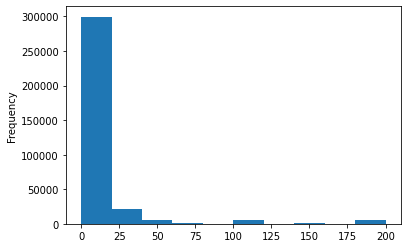

In [65]:
df['non_alpha_prop'].plot.hist()

In [66]:
candidates = df[
    (df['stw_capital'] == 0)
    & (df['ends_punct'] == 0)
    # & (df['non_alpha_prop'] > 0)
    & (df['is_punct'] == 0)
    & (df['is_digit'] == 0)
    & (df['stw_elision'] == 0)
    & (df['operation'] != 'delete')
]
candidates

,id,content,wc,file,len,stw_capital,stw_elision,is_capitalized,non_alpha_prop,ends_punct,freq,is_punct,is_stopword,is_digit,is_in_dict,correction,operation
24,PAG_00000001_ST000025,an,0.440000,../Layout_article_dataset/train/3+c/cb32777055...,2,0,0,0,0,0,86,0,0,0,1,an,keep
35,PAG_00000001_ST000036,an,0.685000,../Layout_article_dataset/train/3+c/cb32777055...,2,0,0,0,0,0,86,0,0,0,1,an,keep
43,PAG_00000001_ST000044,mois,0.487500,../Layout_article_dataset/train/3+c/cb32777055...,4,0,0,0,0,0,163,0,0,0,1,mois,keep
49,PAG_00000001_ST000050,an,0.400000,../Layout_article_dataset/train/3+c/cb32777055...,2,0,0,0,0,0,86,0,0,0,1,an,keep
53,PAG_00000001_ST000054,&amp;,0.580000,../Layout_article_dataset/train/3+c/cb32777055...,5,0,0,0,40,0,23,0,0,0,0,&amp;,keep
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338578,PAG_00000016_ST000437,tous,0.442500,../Layout_article_dataset/train/1c/cb42745757w...,4,0,0,0,0,0,608,0,1,0,1,tous,keep
338579,PAG_00000016_ST000438,les,0.416667,../Layout_article_dataset/train/1c/cb42745757w...,3,0,0,0,0,0,5838,0,1,0,1,les,keep
338580,PAG_00000016_ST000439,dimanches,0.663333,../Layout_article_dataset/train/1c/cb42745757w...,9,0,0,0,0,0,14,0,0,0,1,dimanches,keep
338581,PAG_00000016_ST000440,et,0.455000,../Layout_article_dataset/train/1c/cb42745757w...,2,0,0,0,0,0,6847,0,1,0,1,et,keep


In [67]:
def correct(candidate):
    re_samechar = re.compile(r'([a-z])\1{2,}')
    candidate = re.sub(re_samechar, r'\1', candidate)
    suggestions = sym_spell.lookup(candidate, Verbosity.CLOSEST,
                                  max_edit_distance=1, include_unknown=True,
                                  transfer_casing=True)
    newterm = suggestions[0].term
    return newterm
    
        
corrections = candidates['content'].apply(correct)
corrections

24               an
35               an
43             mois
49               an
53            &amp;
            ...    
338578         tous
338579          les
338580    dimanches
338581           et
338582       jeudis
Name: content, Length: 225371, dtype: object

In [68]:
df['correction'].update(corrections)
df.loc[df['content'] != df['correction'], 'operation'] = 'substitute'
df[df['operation'] == 'substitute']

,id,content,wc,file,len,stw_capital,stw_elision,is_capitalized,non_alpha_prop,ends_punct,freq,is_punct,is_stopword,is_digit,is_in_dict,correction,operation
60,PAG_00000001_ST000061,(IV,0.300000,../Layout_article_dataset/train/3+c/cb32777055...,3,0,0,1,33,0,5,0,0,0,0,IV,substitute
158,PAG_00000001_ST000159,(le,0.660000,../Layout_article_dataset/train/3+c/cb32777055...,3,0,0,0,33,0,16,0,0,0,0,le,substitute
177,PAG_00000001_ST000178,lÿ-Journal,0.796000,../Layout_article_dataset/train/3+c/cb32777055...,10,0,0,0,10,0,1,0,0,0,0,lÿ-journal,substitute
194,PAG_00000001_ST000195,«le,0.406667,../Layout_article_dataset/train/3+c/cb32777055...,3,0,0,0,66,0,25,0,0,0,0,le,substitute
267,PAG_00000001_ST000268,elle',0.560000,../Layout_article_dataset/train/3+c/cb32777055...,5,0,0,0,20,0,1,0,0,0,0,elle,substitute
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338410,PAG_00000016_ST000269,n°,0.520000,../Layout_article_dataset/train/1c/cb42745757w...,2,0,0,0,0,0,16,0,0,0,0,ne,substitute
338426,PAG_00000016_ST000285,renouvelants,0.767500,../Layout_article_dataset/train/1c/cb42745757w...,12,0,0,0,0,0,8,0,0,0,0,renouvelant,substitute
338517,PAG_00000016_ST000376,.Direc,0.565000,../Layout_article_dataset/train/1c/cb42745757w...,6,0,0,0,16,0,1,0,0,0,0,Direc,substitute
338523,PAG_00000016_ST000382,4“,1.000000,../Layout_article_dataset/train/1c/cb42745757w...,2,0,0,0,50,0,1,0,0,0,0,45,substitute


In [23]:
df[df['content'] == 'dé']

,id,content,wc,file,len,stw_capital,stw_elision,is_capitalized,non_alpha_prop,ends_punct,freq,is_punct,is_stopword,is_digit,is_in_dict,correction,operation
4212,PAG_00000002_ST002318,dé,1.000,../Layout_article_dataset/test/3c+/cb32888022x...,2,0,0,0,0,0,15,0,0,0,1,dé,keep
14635,PAG_00000002_ST000969,dé,0.960,../Layout_article_dataset/test/3c+/cb34458454m...,2,0,0,0,0,0,15,0,0,0,1,dé,keep
18167,PAG_00000003_ST000074,dé,0.910,../Layout_article_dataset/test/3c+/cb34458454m...,2,0,0,0,0,0,15,0,0,0,1,dé,keep
18274,PAG_00000003_ST000181,dé,0.910,../Layout_article_dataset/test/3c+/cb34458454m...,2,0,0,0,0,0,15,0,0,0,1,dé,keep
18574,PAG_00000003_ST000481,dé,0.860,../Layout_article_dataset/test/3c+/cb34458454m...,2,0,0,0,0,0,15,0,0,0,1,dé,keep
23689,PAG_00000004_ST000714,dé,0.910,../Layout_article_dataset/test/3c+/cb34458454m...,2,0,0,0,0,0,15,0,0,0,1,dé,keep
36847,PAG_00000008_ST000140,dé,1.000,../Layout_article_dataset/test/2c/cb32889134f/...,2,0,0,0,0,0,15,0,0,0,1,dé,keep
37151,PAG_00000008_ST000444,dé,1.000,../Layout_article_dataset/test/2c/cb32889134f/...,2,0,0,0,0,0,15,0,0,0,1,dé,keep
43197,PAG_00000017_ST000205,dé,0.785,../Layout_article_dataset/test/2c/cb32889134f/...,2,0,0,0,0,0,15,0,0,0,1,dé,keep
47080,PAG_00000022_ST000645,dé,1.000,../Layout_article_dataset/test/2c/cb32889134f/...,2,0,0,0,0,0,15,0,0,0,1,dé,keep


In [20]:
for file in tqdm(df['file'].unique()):
    print(file)
    folderpath = os.path.dirname(file)
    filename = os.path.basename(file)
    filename = filename.replace('.xml', '_clean.xml')
    
    with open(file, encoding='utf=8') as f:
        soup = BeautifulSoup(f.read(), features='lxml')
            
    df_delete = df[
        (df['file'] == file)
        & (df['operation'] == 'delete')
    ]
    
    for tag_id in df_delete['id'].unique():
        tag = soup.find('string', attrs={'id': tag_id})
        tag.extract()
    
    df_sub = df[
        (df['file'] == file)
        & (df['operation'] == 'substitute')
    ]
    
    for tag_id, corr in zip(df_sub['id'].unique(), df_sub['correction'].unique()):
        tag = soup.find('string', attrs={'id': tag_id})
        tag['content'] = corr
        
    with open(f'{folderpath}/{filename}', 'w', encoding='utf-8') as f:
        f.write(soup.prettify())
    
    # break

  0%|                                                     | 0/6 [00:00<?, ?it/s]

../Layout_article_dataset/test/3c+/cb32888022x/bpt6k6522392v/bpt6k6522392v.xml


 17%|███████▌                                     | 1/6 [00:08<00:42,  8.60s/it]

../Layout_article_dataset/test/3c+/cb34458454m/bpt6k12628065/bpt6k12628065.xml


 33%|███████████████                              | 2/6 [00:40<01:29, 22.39s/it]

../Layout_article_dataset/test/2c/cb328152109/bpt6k65474640/bpt6k65474640.xml


 50%|██████████████████████▌                      | 3/6 [00:46<00:44, 14.70s/it]

../Layout_article_dataset/test/2c/cb32889134f/bpt6k884084x/bpt6k884084x.xml


 67%|██████████████████████████████               | 4/6 [00:54<00:24, 12.19s/it]

../Layout_article_dataset/test/1c/cb328362537/bpt6k927011z/bpt6k927011z.xml


 83%|█████████████████████████████████████▌       | 5/6 [00:57<00:08,  8.81s/it]

../Layout_article_dataset/test/1c/cb32837463b/bpt6k5558383c/bpt6k5558383c.xml


100%|█████████████████████████████████████████████| 6/6 [00:58<00:00,  9.82s/it]


In [133]:
df[df['file'] == 'bpt6k947499g'].to_csv('test.csv', index=False)

## Post correcting full text

In [5]:

bi_dictionary_path = 'fr_dic_bigram.txt'
# 0, 1 pour dic unigramme, 0,2 pour dic bigramme
sym_spell.load_bigram_dictionary(dictionary_path, 0, 2)

True

In [9]:
txt = '''Samedi, IO novembre, Mgr Saltot de Brobèquc, protonolairc apostolique, était installé chanoine titulaire de la Métropole.'''

# txt = '''PermettezàvotreAumônier,devousenvoyer,touslesmoissipossible,cebulletinbaptisédunomde«PelitEchoduai1"Régi-mentd'Infanterie».'''
suggestions = sym_spell.lookup_compound(txt, max_edit_distance=1, transfer_casing=True)

for sug in suggestions:
    print(sug)

Samedi IO novembre Mgr Salto de Bob èque protons laird apostolique était installé chanoine titulaire de la Métropole, 12, 0


In [10]:
txt = '''Samedi,IOnovembre,MgrSaltotdeBrobèquc,protonolaircapostolique,étaitinstalléchanoinetitulairedelaMétropole.'''

In [11]:
t = sym_spell.word_segmentation(txt)
t.corrected_string

'Samedi Novembre mgr Salto der obèques protonotaire apostolique tait installé chanoine titulaire de la Métropole'